In [1]:
import os
from six.moves import cPickle as pickle
import numpy as np
import scipy.io as sio
import scipy.misc as spm
import datetime
import matplotlib.image as plt
from IPython.display import Image, display

IMG_DIR = r'/home/ubuntu/coding/cnn/datasets/imdb_crop'
MAT_FILE = r'/home/ubuntu/coding/cnn/datasets/imdb_crop/imdb.mat'

In [2]:
def reformat_date(mat_date):
    dt = datetime.date.fromordinal(np.max([mat_date - 366, 1])).year
    return dt

In [3]:
def create_path(path):
    return os.path.join(IMG_DIR, path[0])

In [4]:
mat_struct = sio.loadmat(MAT_FILE)
data_set = [data[0] for data in mat_struct['imdb'][0, 0]]

keys = ['dob',
    'photo_taken',
    'full_path',
    'gender',
    'name',
    'face_location',
    'face_score',
    'second_face_score',
    'celeb_names',
    'celeb_id'
]

imdb_dict = dict(zip(keys, np.asarray(data_set)))
imdb_dict['dob'] = [reformat_date(dob) for dob in imdb_dict['dob']]
imdb_dict['full_path'] = [create_path(path) for path in imdb_dict['full_path']]

# Add 'age' key to the dictionary
imdb_dict['age'] = imdb_dict['photo_taken'] - imdb_dict['dob']

print("Dictionary created...")

Dictionary created...


Converting 0 samples. (0=all samples)
Processing 0 of 460723


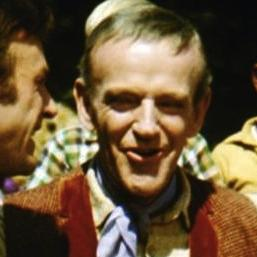

Second face score: 1.1189733571573068 Age: 69 Gender: 1.0
Processing 200000 of 460723


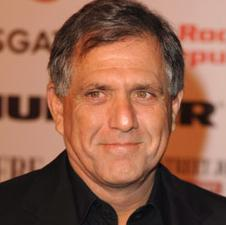

Second face score: nan Age: 55 Gender: 1.0
Processing 400000 of 460723


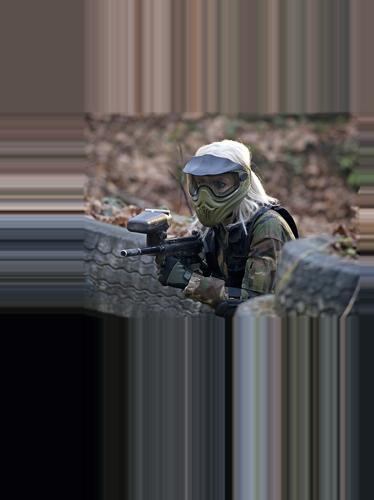

Second face score: nan Age: 27 Gender: 0.0


In [5]:
print("Converting {} samples. (0=all samples)".format(0))

raw_path = imdb_dict['full_path']
raw_age = imdb_dict['age']
raw_gender = imdb_dict['gender']
raw_sface = imdb_dict['second_face_score']

age = []
gender = []
imgs = []
for i, sface in enumerate(raw_sface):
    if i%200000==0:
        print("Processing {0} of {1}".format(i,len(raw_sface)))
        display(Image(filename=raw_path[i]))
        print("Second face score: {}".format(sface), end=" ")
        print("Age: {}".format(raw_age[i]), end=" ")
        print("Gender: {}".format(raw_gender[i]))
    if np.isnan(sface) and raw_age[i] >= 0 and not np.isnan(raw_gender[i]):
        age.append(raw_age[i])
        gender.append(raw_gender[i])
        imgs.append(raw_path[i])

In [6]:
# Convert images path to images.
if os.path.exists(os.getcwd()+"pkl_folder/imdb_data_train.pkl") and os.path.exists(
    os.getcwd()+"pkl_folder/imdb_data_valid.pkl") and os.path.exists(
    os.getcwd()+"pkl_folder/imdb_data_test.pkl"):
    print("Dataset already present - Skip convert images to images.")
else:
    print("Converting images path to images.")
    real_imgs = []
    tmp = []
    for img_path in imgs:
        tmp = np.asarray(spm.imresize(spm.imread(img_path, flatten=1), (128, 128)), dtype=np.float32)
        real_imgs.append(tmp)

    print("Original size: {0} - Preprocess size: {1}".format(len(raw_sface), len(real_imgs)))

Converting images path to images.
Original size: 460723 - Preprocess size: 242434


In [20]:
def create_pickle(force=False):
    if os.path.exists(os.getcwd+"pkl_folder/imdb_data_train.pkl") and os.path.exists(
        os.getcwd()+"pkl_folder/imdb_data_valid.pkl") and os.path.exists(
        os.getcwd()+"pkl_folder/imdb_data_test.pkl") and not force:
        # You may override by setting force=True.
        print("Dataset already present - Skip pickling.")
    else:
        # Dump data train
        data_train = {'image_inputs': np.array(real_imgs[0:60000]),
                'age_labels': np.array(age[0:60000]),
                'gender_labels': np.array(gender[0:60000])
                }
        print("Dataset train size: {}".format(len(data_train['image_inputs'])))
        with open(os.path.join(os.getcwd(),"pkl_folder/imdb_data_train.pkl"),'wb') as f:
            pickle.dump(data_train, f)
        print("Dataset train size: imdb_data_train.pkl")

        # Dump data valid
        data_valid = {'image_inputs': np.array(real_imgs[60000:80000]),
                'age_labels': np.array(age[60000:80000]),
                'gender_labels': np.array(gender[60000:80000])
                }
        print("Dataset valid size: {}".format(len(data_valid['image_inputs'])))
        with open(os.path.join(os.getcwd(),"pkl_folder/imdb_data_valid.pkl"),'wb') as f:
            pickle.dump(data_valid, f)
        print("Dataset train size: imdb_data_valid.pkl")

        # Dump data test
        data_test = {'image_inputs': np.array(real_imgs[80000:100000]),
                'age_labels': np.array(age[80000:100000]),
                'gender_labels': np.array(gender[80000:100000])
                }
        print("Dataset test size: {}".format(len(data_test['image_inputs'])))
        with open(os.path.join(os.getcwd(),"pkl_folder/imdb_data_test.pkl"),'wb') as f:
            pickle.dump(data_test, f)
        print("Dataset test size: imdb_data_test.pkl")

create_pickle()

Dataset train size: 60000
Dataset train size: imdb_data_train.pkl
Dataset valid size: 20000
Dataset train size: imdb_data_valid.pkl
Dataset test size: 20000
Dataset test size: imdb_data_test.pkl


In [19]:
def make_arrays(nb_rows, img_size, img_depth=3):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size, img_depth), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def convert_label(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            org_dataset = pickle.load(f)
            dataset, label = make_arrays(valid_size, image_size)
            train_dataset, train_labels = make_arrays(train_size, image_size)
            # let's shuffle to have random dataset
            np.random.shuffle(dataset)
            
            
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    return dataset, label


for label, pickle_file in enumerate(pickle_files):
    # print(pickle_file)
    
    try:
      with open(pickle_file, 'rb') as f:
        smile_nonsmile_set = pickle.load(f)

        # let's shuffle the smile / nonsmile class
        # to have random validation and training set
        np.random.shuffle(smile_nonsmile_set)
        if valid_dataset is not None:
          valid_smile_nonsmile = smile_nonsmile_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_smile_nonsmile
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class

        train_smile_nonsmile = smile_nonsmile_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_smile_nonsmile
        train_labels[start_t:end_t] = label

        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    return valid_dataset, valid_labels, train_dataset, train_labels

60608